In [1]:
import torch
import numpy as np
import pandas as pd

from model import PrefixNet

/cluster/scratch/goezsoy/miniconda3/envs/cond_text_gen_project/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.manifold import TSNE, Isomap, MDS
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Using device: cpu


/cluster/scratch/goezsoy/miniconda3/envs/cond_text_gen_project/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/cluster/scratch/goezsoy/miniconda3/envs/cond_text_gen_project/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


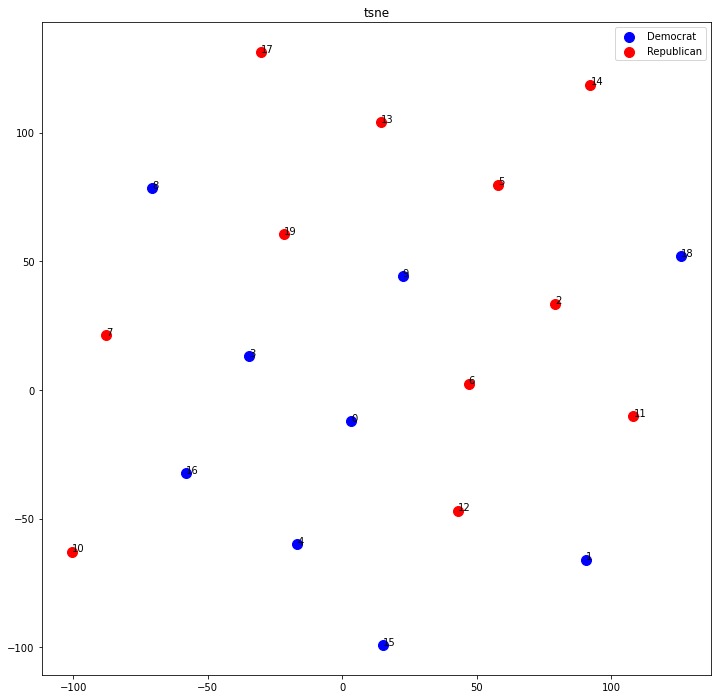

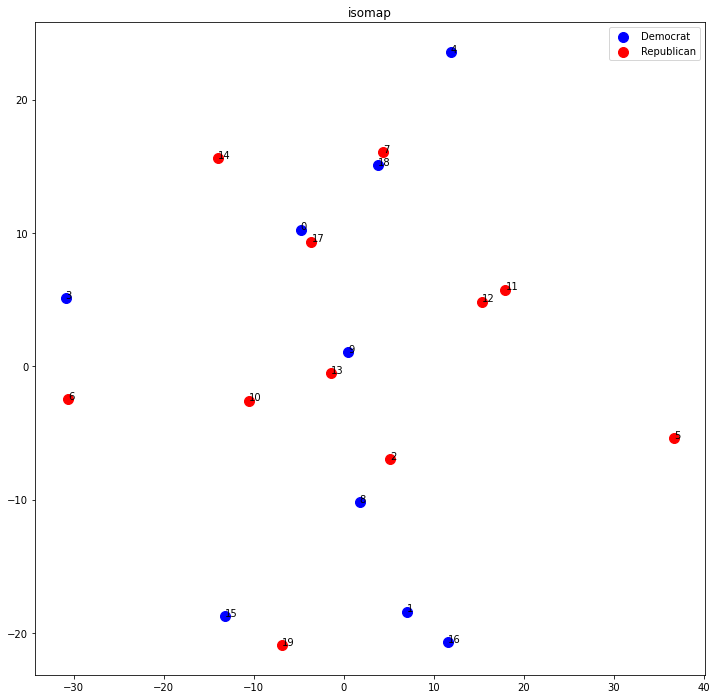

In [19]:
# setting device on GPU if available, else CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

cfg= {'batch_size':8,'prefix_len':3,'embed_size_per_token':100,'speaker_size':20,'epoch':90,'encoded':'encoded_bioguide_ids','freeze_gpt':False}

model = PrefixNet(cfg)

model_name=f'24may_prefix_tuning_prlen{cfg["prefix_len"]}_embsize{cfg["embed_size_per_token"]}_speaksize{cfg["speaker_size"]}_maxseqlen256_batch8_8_epoch{cfg["epoch"]}.pt'
checkpoint = torch.load('/cluster/scratch/goezsoy/nlp_lss_checkpoints/'+model_name,map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

X = model.embedding_layer.weight.detach().numpy()

X_embedded_isomap = Isomap(n_components=2).fit_transform(X)
X_embedded_tsne = TSNE(n_components=2).fit_transform(X)

speaker_labels = np.arange(0,cfg['speaker_size'])
processed_df = pd.read_csv('/cluster/scratch/goezsoy/nlp_lss_datasets/processed_df.csv')
meta_df= processed_df[processed_df[cfg['encoded']].isin(speaker_labels)].drop_duplicates(subset=cfg['encoded'])

# first plot
group = meta_df.term_party.values
cdict = {'Democrat': 'blue', 'Republican': 'red'}

fig, ax = plt.subplots(figsize=(12,12))

for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(X_embedded_tsne[ix,0], X_embedded_tsne[ix,1], c = cdict[g], label = g, s = 100)

for i, txt in enumerate(list(speaker_labels)):
    ax.annotate(txt, (X_embedded_tsne[i,0], X_embedded_tsne[i,1]))
ax.legend()
ax.set_title('tsne')

plt.show()

#second plot
fig2, ax2 = plt.subplots(figsize=(12,12))

for g in np.unique(group):
    ix = np.where(group == g)
    ax2.scatter(X_embedded_isomap[ix,0], X_embedded_isomap[ix,1], c = cdict[g], label = g, s = 100)

for i, txt in enumerate(list(speaker_labels)):
    ax2.annotate(txt, (X_embedded_isomap[i,0], X_embedded_isomap[i,1]))
ax2.legend()
ax2.set_title('isomap')

plt.show()